In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


# Import data

In [2]:
import pickle
import gdown

In [3]:
data_cleaned_url = "https://drive.google.com/uc?id=1-I5k-1NlFozfdbRb5JVy7nEfQEXqYP9c"
output = './Download/data_cleaned_gdown.zip'
gdown.download(data_cleaned_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-I5k-1NlFozfdbRb5JVy7nEfQEXqYP9c
To: /home/anthony/Documents/Research-Mapping-Uncanny-Valley/Code/Download/data_cleaned_gdown.zip
786MB [00:14, 54.5MB/s] 


'./Download/data_cleaned_gdown.zip'

module zipfile does not support the compression format (I don't know why). 
You can use
```bash
sudo apt-get update
sudo apt-get install unzip
unzip ./Download/data_cleaned_gdown.zip
```
to unzip the file to `/Code/Download` directory

In [3]:
with open('./Download/data_cleaned.pickle', 'rb') as handle:
    data_cleaned = pickle.load(handle)

In [4]:
data_cleaned['RS_2020_nosleep']

,id,title,selftext,score,title_language,selftext_language
0,gxsa0i,Do NOT Open Your Eyes... (Pt. 1),This is the only rule of our household. If you...,1,en,en
1,gxs6jf,Do NOT open your eyes. (The Beginning),This is the only rule of our household. If you...,1,en,en
3,gxrytp,My Best Friend Saw Bugs Under His Skin,It is hard for me to talk about my old friend ...,1,de,en
5,gxrnj7,"I picked up a hitchhiker by mistake, now he's ...",They say the devil is in the details. Well th...,1,en,en
6,gxrm8v,I'm tasked with killing nameless things out in...,"""Any sign of 'em yet?"" \n\nI continued staring...",1,en,en
...,...,...,...,...,...,...
21218,eihp0m,Hylophobia,*There is no cure for trauma. Once it enters t...,1,vi,en
21219,eihmg7,I adopted my late sisters orphaned child. This...,"I knew Persephone would need time to adjust, b...",1,en,en
21221,eihgtp,My first paranormal experience!!,"This isnt much, but this is surely the first u...",1,en,en
21223,eigzgj,I met the demon under my bed... Its not what I...,"Okay. for context, this story started about a ...",1,en,en


# Cosine similarity with emotions

In [5]:
from util import semantic_search
sents_emotion_vec = semantic_search(data_cleaned['RS_2020_nosleep']['selftext'][5], verbose = False)
sents_emotion_vec

array([[ 0.21698272,  0.20960012,  0.19537641, ..., -0.02441338,
        -0.0326806 , -0.06282185],
       [ 0.42663223,  0.37293845,  0.36481518, ...,  0.10002041,
         0.05779833,  0.03616553],
       [ 0.30050087,  0.21807092,  0.19975151, ...,  0.03358124,
        -0.00511191, -0.02358057],
       ...,
       [ 0.55303162,  0.49452001,  0.4796218 , ..., -0.03603059,
        -0.06295857, -0.07457595],
       [ 0.26004642,  0.24877664,  0.22177438, ..., -0.0289279 ,
        -0.04870765, -0.09610555],
       [ 0.23916952,  0.2003721 ,  0.14978789, ..., -0.09678131,
        -0.12432525, -0.17019036]])

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sents_emotion_vec = scaler.fit_transform(sents_emotion_vec)

In [7]:
scaled_sents_emotion_vec

array([[-0.58307311, -0.54791709, -0.54447741, ..., -0.20292152,
        -0.092175  , -0.13933973],
       [-0.02789105, -0.11317501, -0.09906804, ...,  0.39033676,
         0.33625014,  0.30587438],
       [-0.36190504, -0.52537116, -0.53297644, ...,  0.07357725,
         0.038365  ,  0.03715519],
       ...,
       [ 0.30683274,  0.21042704,  0.20272799, ..., -0.25830845,
        -0.23554366, -0.19220596],
       [-0.46903424, -0.44364467, -0.47508417, ..., -0.22444521,
        -0.16806437, -0.28903936],
       [-0.52431927, -0.57247844, -0.66431749, ..., -0.54794736,
        -0.52611991, -0.62224954]])

# Construct E, S matrices

## Idea: maybe a custom layer in the end before the last layer.

For each sentence in a document, we have a (1,768) sentence embeddings. Combining all sentence embeddings, we have a matrix S of dimension (N,768)

$$
S = 
\begin{bmatrix}
    s_{1,1} & s_{1,2} & s_{1,3} & \dots  & s_{1,d} \\
    s_{2,1} & s_{2,2} & s_{2,3} & \dots  & s_{2,d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    s_{N,1} & s_{N,2} & s_{N,3} & \dots  & s_{N,d}
\end{bmatrix} \\
\text{where d is the embedding dimension (in this case, 768) and N is number of sentences in a document}
$$

Based on these embeddings, we can get the emotional scores by calculating the cosine similarity between each motion and a sentence. We can combine these scores into another matrix E. E has dimension of (27,N)

$$
E = 
\begin{bmatrix}
    e_{1,1} & e_{2,1} & e_{3,1} & \dots  & e_{N,1} \\
    e_{1,2} & e_{2,2} & e_{3,2} & \dots  & e_{N,2} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    e_{1,27} & e_{2,27} & e_{3,27} & \dots  & e_{N,27}
\end{bmatrix} \\
\text{where N is number of sentences in a document}
$$

Natually, we want to have the same dimension for each post (document). So, we can multiply these two matrices together: 

$$E\times S$$
$$(27,N) \times (N,768) = (27,768)$$

Then we will have the same dimension for each post.

In [11]:
from util import semantic_search
from sentence_transformers import SentenceTransformer
import spacy
nlp = spacy.load('en_core_web_lg')
import swifter
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def apply_semantic_search(row):
    E = semantic_search(row['selftext'],sort_by='alphabetical', verbose = False)
    return np.transpose(E)

def apply_scaled_E(row):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(row['E'])

def apply_SBERT(row):
    model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

    doc = nlp(row['selftext'])
    #Our sentences we like to encode
    sentences = [repr(sent) for sent in doc.sents]

    #Sentences are encoded by calling model.encode()
    S = model.encode(sentences)
    return S

feature_dfs = dict()

for key, df in data_cleaned.items():
    if not key.endswith('comments'):
        if key.endswith(('self','nosleep')):
            print("\n\n======================\n")
            print("Dataset:", key)
            print("\nCalculating...")
            df_new = df.head(1000).copy()
            df_new['E'] = df_new.swifter.progress_bar(enable=True, desc="Calculating Emotion Matrix E").apply(apply_semantic_search, axis=1)
            df_new['scaled_E'] = df_new.swifter.progress_bar(enable=True, desc="Scaling E").apply(apply_scaled_E, axis=1)
            df_new['S'] = df_new.swifter.progress_bar(enable=True, desc="Calculating SBERT embeddings S").apply(apply_SBERT, axis=1)
            df_new['scaled_E*S'] = df_new.swifter.progress_bar(enable=True, desc="Calculating multiplication of scaled E and S").apply(lambda x: np.matmul(x['scaled_E'], x['S']), axis=1)
            
            feature_dfs[key] = df_new




Dataset: RS_2020_nosleep

Calculating...






Dataset: RS_2020_self

Calculating...


In [12]:
pickle.dump(feature_dfs, open("./Download/feature_dfs.pickle", "wb" ))

## Re-import featue_dfs

In [13]:
with open('./Download/feature_dfs.pickle', 'rb') as handle:
    feature_dfs = pickle.load(handle)

## Pre-processing

Extract features

In [14]:
non_creepy_features = np.array(feature_dfs['RS_2020_self']['scaled_E*S'].to_list())
creepy_features = np.array(feature_dfs['RS_2020_nosleep']['scaled_E*S'].to_list())

features = np.concatenate((creepy_features, non_creepy_features))
labels = np.concatenate((np.zeros(len(non_creepy_features)), np.ones(len(creepy_features))))

Show shapes

In [15]:
print(features.shape)
print(labels.shape)

(2000, 27, 768)
(2000,)


Shuffle the features and labels correspondingly

In [16]:
from sklearn.utils import shuffle

features, labels = shuffle(features, labels)
print(labels)

[0. 1. 1. ... 0. 1. 1.]


Scale to 0 to 1

In [17]:
# flatten each matrix
features.reshape((features.shape[0],features.shape[1]*features.shape[2]))
features.shape

(2000, 27, 768)

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features.reshape((features.shape[0],features.shape[1]*features.shape[2])))
scaled_features = scaled_features.reshape(features.shape)
print(scaled_features, labels)

[[[0.45158834 0.39958594 0.46386614 ... 0.09625109 0.77999941 0.60210577]
  [0.48840179 0.42031904 0.42289717 ... 0.0823121  0.87732851 0.7242431 ]
  [0.23069307 0.69981898 0.81878588 ... 0.05374356 0.31135857 0.72202441]
  ...
  [0.18143064 0.67122877 0.72597831 ... 0.77162082 0.31065062 0.63867106]
  [0.85911608 0.43389607 0.45735651 ... 0.22666264 0.72829174 0.1595353 ]
  [0.63623709 0.32310516 0.58401514 ... 0.57882507 0.59607988 0.56162569]]

 [[0.497172   0.3946385  0.51446808 ... 0.0918968  0.78310183 0.56076889]
  [0.51569877 0.45358778 0.46300599 ... 0.06966471 0.87584066 0.69404485]
  [0.2572685  0.69806368 0.85148442 ... 0.04038505 0.31141238 0.67961302]
  ...
  [0.19897237 0.61454952 0.77802085 ... 0.7966681  0.31137624 0.63653817]
  [0.87684128 0.40497923 0.5188632  ... 0.20717498 0.72165528 0.1067987 ]
  [0.63782095 0.33006175 0.60192248 ... 0.5799107  0.57547104 0.55474804]]

 [[0.50455058 0.42371824 0.5328646  ... 0.10000095 0.75489812 0.53741527]
  [0.56315746 0.472836

Split the data

- [ ] 70% train, 15% val, 15% test
- [x] 80% train, 10% val, 10% test
- [ ] 60% train, 20% val, 20% test

In [19]:
from sklearn.model_selection import train_test_split

X = scaled_features.reshape(-1, 27, 768, 1)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# Recall: our best "hand-tuned" model

```python
model = keras.Sequential([
    keras.layers.Dense(units = 303, input_shape = (769,), activation = 'relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dense(units = 64, activation = 'relu'),
    keras.layers.Dense(units = 32, activation = 'relu'),
    keras.layers.Dense(units = 16, activation = 'relu'),
    keras.layers.Dense(units = 1, activation = 'sigmoid')
])
```

## Model here

In [20]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [93]:
model = Sequential([
    Conv2D(64, (2,2), input_shape = X.shape[1:], activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.1),
    
    Dense(units = 1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
             optimizer = "Adam", # you can tune the learning rate here. Default lr = 0.01
             metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 30)

Epoch 1/30
50/50 [==============================] - 1s 17ms/step - loss: 0.8809 - accuracy: 0.5144 - val_loss: 0.6643 - val_accuracy: 0.6500
Epoch 2/30
50/50 [==============================] - 1s 15ms/step - loss: 0.5451 - accuracy: 0.7231 - val_loss: 0.3402 - val_accuracy: 0.9400
Epoch 3/30
50/50 [==============================] - 1s 15ms/step - loss: 0.3274 - accuracy: 0.8737 - val_loss: 0.2157 - val_accuracy: 0.9050
Epoch 4/30
50/50 [==============================] - 1s 15ms/step - loss: 0.3032 - accuracy: 0.8756 - val_loss: 0.2296 - val_accuracy: 0.9050
Epoch 5/30
50/50 [==============================] - 1s 15ms/step - loss: 0.2790 - accuracy: 0.8944 - val_loss: 0.3360 - val_accuracy: 0.8550
Epoch 6/30
50/50 [==============================] - 1s 15ms/step - loss: 0.2636 - accuracy: 0.9081 - val_loss: 0.1598 - val_accuracy: 0.9450
Epoch 7/30
50/50 [==============================] - 1s 15ms/step - loss: 0.2387 - accuracy: 0.9206 - val_loss: 0.1651 - val_accuracy: 0.9400
Epoch 8/30
50

In [95]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.1388 - accuracy: 0.9500


[0.13882271945476532, 0.949999988079071]

In [81]:
history.history

{'loss': [0.7257594466209412,
  0.4061872065067291,
  0.2810940146446228,
  0.28455784916877747,
  0.24052120745182037,
  0.32429349422454834,
  0.2344907820224762,
  0.23350727558135986,
  0.22135426104068756,
  0.21554894745349884,
  0.20446152985095978,
  0.22217626869678497,
  0.21152402460575104,
  0.1885930895805359,
  0.1981273889541626,
  0.21038810908794403,
  0.1897449642419815,
  0.17066071927547455,
  0.16098220646381378,
  0.1500529944896698,
  0.1863759160041809,
  0.1484728455543518,
  0.14701558649539948,
  0.14109860360622406,
  0.1358884871006012,
  0.1298246532678604,
  0.13727745413780212,
  0.1292582005262375,
  0.12267307192087173,
  0.11597440391778946,
  0.1199750006198883,
  0.12443175911903381,
  0.12122596800327301,
  0.1142381876707077,
  0.12468563765287399,
  0.09972534328699112,
  0.11822706460952759,
  0.09660541266202927,
  0.1056113988161087,
  0.09912773221731186],
 'accuracy': [0.6118749976158142,
  0.8287500143051147,
  0.8849999904632568,
  0.88625

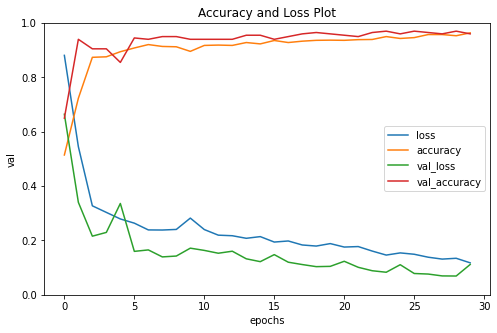

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.title("Accuracy and Loss Plot")
plt.xlabel("epochs")
plt.ylabel("val")
plt.grid = True
plt.gca().set_ylim(0,1)

plt.savefig('./Download/acc_plot')

# Visualizations

In [56]:
emotions = ['Admiration',
                'Adoration',
                'Aesthetic Appreciation',
                'Amusement',
                'Anxiety',
                'Awe',
                'Awkwardness',
                'Boredom',
                'Calmness',
                'Confusion',
                'Craving',
                'Disgust',
                'Empathetic pain',
                'Entrancement',
                'Envy',
                'Excitement',
                'Fear',
                'Horror',
                'Interest',
                'Joy',
                'Nostalgia',
                'Romance',
                'Sadness',
                'Satisfaction',
                'Sexual desire',
                'Sympathy',
                'Triumph',
              ]

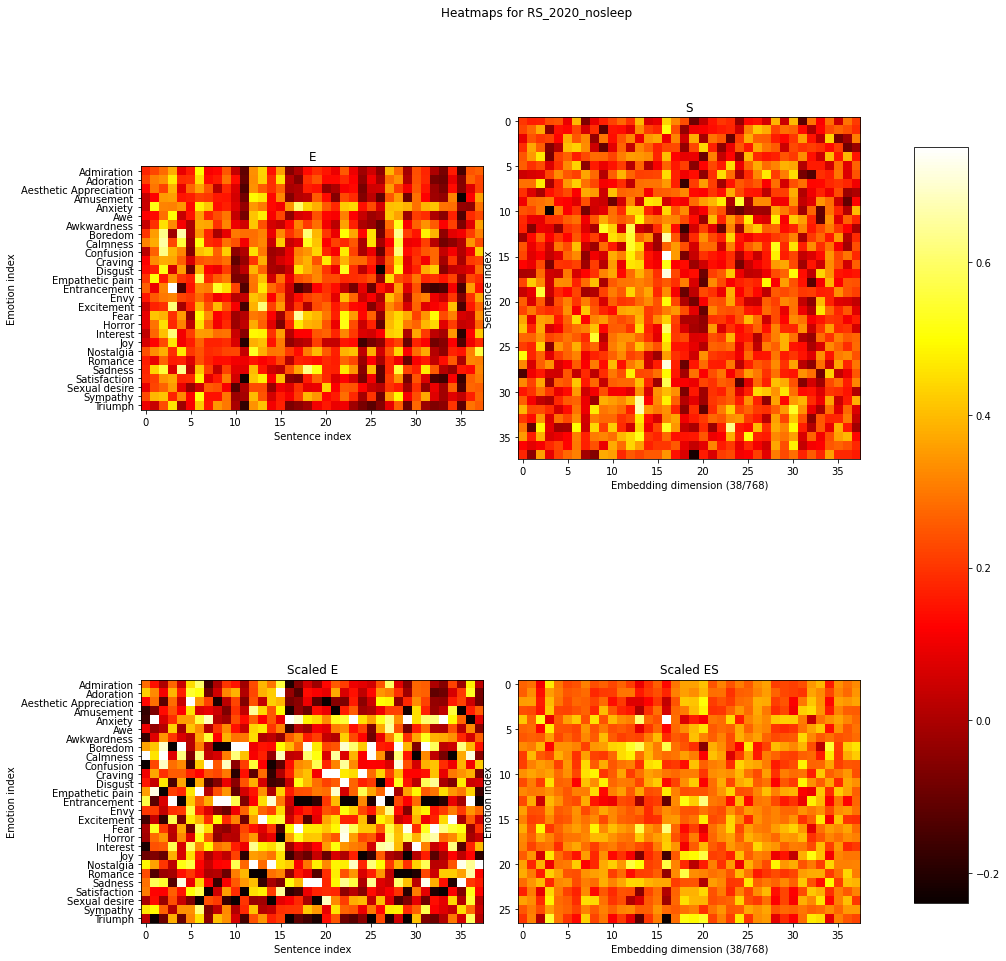

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

dataset_str = 'RS_2020_nosleep'
idx = 1
creepy_E = feature_dfs[dataset_str]['E'].iloc[idx]
creepy_scaled_E = feature_dfs[dataset_str]['scaled_E'].iloc[idx]
creepy_S = feature_dfs[dataset_str]['S'].iloc[idx]
creepy_scaled_ES = feature_dfs[dataset_str]['scaled_E*S'].iloc[idx]

fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.suptitle(f'Heatmaps for {dataset_str}')
axs[0,0].imshow(creepy_E, cmap='hot')
axs[0,0].set_title('E')
axs[0,0].set(ylabel='Emotion index', xlabel='Sentence index')
plt.sca(axs[0, 0])
plt.yticks(range(len(emotions)), emotions)

axs[1,0].imshow(creepy_scaled_E, cmap='hot')
axs[1,0].set_title('Scaled E')
axs[1,0].set(ylabel='Emotion index', xlabel='Sentence index')
plt.sca(axs[1, 0])
plt.yticks(range(len(emotions)), emotions)

cutoff_value = creepy_E.shape[1]

axs[0,1].imshow(creepy_S[:,:cutoff_value], cmap='hot')
axs[0,1].set_title('S')
axs[0,1].set(xlabel=f'Embedding dimension ({cutoff_value}/768)', ylabel='Sentence index')

axs[1,1].imshow(creepy_scaled_ES[:,:cutoff_value], cmap='hot')
axs[1,1].set_title('Scaled ES')
axs[1,1].set(xlabel=f'Embedding dimension ({cutoff_value}/768)', ylabel='Emotion index')

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig(f'./Download/Heatmaps for {dataset_str}')

<Figure size 640x480 with 0 Axes>

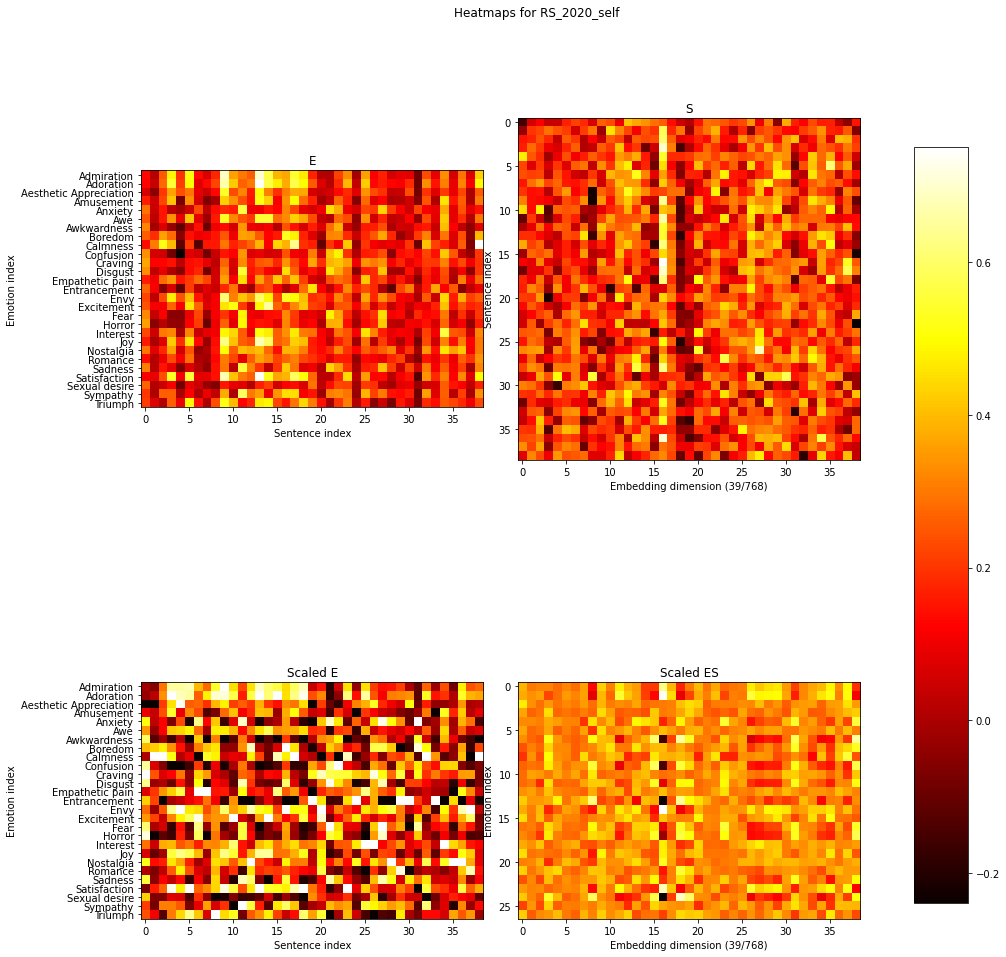

In [88]:
figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')

dataset_str = 'RS_2020_self'
idx = 11
non_creepy_E = feature_dfs[dataset_str]['E'].iloc[idx]
non_creepy_scaled_E = feature_dfs[dataset_str]['scaled_E'].iloc[idx]
non_creepy_S = feature_dfs[dataset_str]['S'].iloc[idx]
non_creepy_scaled_ES = feature_dfs[dataset_str]['scaled_E*S'].iloc[idx]

fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.suptitle(f'Heatmaps for {dataset_str}')
axs[0,0].imshow(non_creepy_E, cmap='hot')
axs[0,0].set_title('E')
axs[0,0].set(ylabel='Emotion index', xlabel='Sentence index')
plt.sca(axs[0, 0])
plt.yticks(range(len(emotions)), emotions)

axs[1,0].imshow(non_creepy_scaled_E, cmap='hot')
axs[1,0].set_title('Scaled E')
axs[1,0].set(ylabel='Emotion index', xlabel='Sentence index')
plt.sca(axs[1, 0])
plt.yticks(range(len(emotions)), emotions)

cutoff_value = non_creepy_E.shape[1]

axs[0,1].imshow(non_creepy_S[:,:cutoff_value], cmap='hot')
axs[0,1].set_title('S')
axs[0,1].set(xlabel=f'Embedding dimension ({cutoff_value}/768)', ylabel='Sentence index')

axs[1,1].imshow(non_creepy_scaled_ES[:,:cutoff_value], cmap='hot')
axs[1,1].set_title('Scaled ES')
axs[1,1].set(xlabel=f'Embedding dimension ({cutoff_value}/768)', ylabel='Emotion index')
fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig(f'./Download/Heatmaps for {dataset_str}')